## Discrete-time competitive Beverton-Holt model

\begin{align}
N_{1,t+1}=\dfrac{r_1N_{1,t}}{1+a_{11}N_{1,t}+a_{12}N_{2,t}} \\
N_{2,t+1}=\dfrac{r_2N_{2,t}}{1+a_{22}N_{2,t}+a_{21}N_{1,t}}
\tag{1}
\end{align}

## Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import pandas as pd
from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('onedork') #grade3

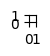

In [2]:
# Dummy plot
fig, ax = plt.subplots(figsize=(0.1, 0.1))
ax.axhline(y=1, color='grey', linestyle='-')
plt.rcParams.update({'font.size': 30})

In [3]:
step=2

In [4]:
# strength of stabilization as measured in our paper
def SOS(r, alpha):
    out = np.zeros(2)
    out[0] = r[1] / (1 + (alpha[0][1] / alpha[1][1]) * (r[1] - 1))
    out[1] = r[0] / (1 + (alpha[1][0] / alpha[0][0]) * (r[0] - 1))
    return out

In [5]:
# calculate log per capita growth rate
def getPCG(r, alpha, N):
    # r is a list of fecundities for spp 1 and 2
    # alpha is a matrix of interaction coefficients where alpha[i][j] is the effect of j on i
    # N is a list of densities for spp 1 and 2
    newN = np.zeros(2)
    newN[0] = r[0] * N[0] / (1 + alpha[0][0] * N[0] + alpha[0][1] * N[1])
    newN[1] = r[1] * N[1] / (1 + alpha[1][0] * N[0] + alpha[1][1] * N[1])
    out = np.zeros(2)
    out[0] = np.log(newN[0]) - np.log(N[0])  # per capita growth rate of species 1
    out[1] = np.log(newN[1]) - np.log(N[1])  # per capita growth rate of species 2
    return out

In [6]:
# figure out the equilibrium density of the focal species' competitor
# given a fixed density of the focal species
def getEqDensity(species, r, alpha, N_star):
    # species = focal species (this one is fixed, density of the other is returned)
    # N_start (a scalar) is the density of the fixed spp
    if species == 1:
        # density of species one is known
        out = (r[1] - 1 - alpha[1][0] * N_star) / alpha[1][1]
    elif species == 2:
        # density of species two is known
        out = (r[0] - 1 - alpha[0][1] * N_star) / alpha[0][0]
    return out

In [7]:
def getNFD(r, alpha, lowN, deltaN):
    # lowN is the low density 
    # and deltaN is the increase in N for the higher density to explore

    # vectors for output
    pgr1, freq1, pgr2, freq2 = np.zeros(2), np.zeros(2), np.zeros(2), np.zeros(2)

    # get low density growth rate for spp 1
    tmpN = np.zeros(2)
    tmpN = np.zeros(2)
    tmpN[0] = lowN  # set density of focal spp
    tmpN[1] = getEqDensity(species=1, r=r, alpha=alpha, N_star=tmpN[0])  # figure out density of its competitor
    tmpOut = getPCG(r=r, alpha=alpha, N=tmpN)
    pgr1[0] = tmpOut[0]
    freq1[0] = tmpN[0] / np.sum(tmpN)

    # get low density growth rate for spp 2
    tmpN = np.zeros(2)
    tmpN[1] = lowN
    tmpN[0] = getEqDensity(species=2, r=r, alpha=alpha, N_star=tmpN[1])
    tmpOut = getPCG(r=r, alpha=alpha, N=tmpN)
    pgr1[1] = tmpOut[1]
    freq1[1] = tmpN[1] / np.sum(tmpN)

    # get higher density growth rate for spp1 1
    tmpN = np.zeros(2)
    tmpN[0] = lowN + deltaN
    tmpN[1] = getEqDensity(species=1, r=r, alpha=alpha, N_star=tmpN[0])
    tmpOut = getPCG(r=r, alpha=alpha, N=tmpN)
    pgr2[0] = tmpOut[0]
    freq2[0] = tmpN[0] / np.sum(tmpN)

    # get higher density growth rate for spp1 2
    tmpN = np.zeros(2)
    tmpN[1] = lowN + deltaN
    tmpN[0] = getEqDensity(species=2, r=r, alpha=alpha, N_star=tmpN[1])
    tmpOut = getPCG(r=r, alpha=alpha, N=tmpN)
    pgr2[1] = tmpOut[1]
    freq2[1] = tmpN[1] / np.sum(tmpN)

    out = {
        "pgr1": pgr1,
        "freq1": freq1,
        "pgr2": pgr2,
        "freq2": freq2
    }
    return out

In [8]:
@jit(nopython=True)
def time_simul(r1,r2,a11,a22,a12,a21,y01,y02):
    tmax = 2
    y1 = np.zeros(tmax)
    y2 = np.zeros(tmax)
    per_cap1 = np.zeros(tmax)
    per_cap2 = np.zeros(tmax)
    y1_relat = np.zeros(tmax)
    y2_relat = np.zeros(tmax)
    y1[0],y2[0] = y01,y02 # initial conditions
    i,stopRun = 0,0
    while stopRun==0: # stops the simulation when the dynamics converges
        per_cap1[i] = r1 / ( 1 + a11 * y1[i] + a12 * y2[i] )
        per_cap2[i] = r2 / ( 1 + a22 * y2[i] + a21 * y1[i] )
        y1[i+1] = y1[i] * per_cap1[i]
        y2[i+1] = y2[i] * per_cap2[i]
        y1_relat[i]=y1[i]/(y1[i]+y2[i])
        y2_relat[i]=y2[i]/(y1[i]+y2[i])
        per_cap1=np.append(per_cap1,per_cap1[i])
        per_cap2=np.append(per_cap2,per_cap2[i])
        y1=np.append(y1,y1[i])
        y2=np.append(y2,y2[i])
        y1_relat=np.append(y1_relat,y1_relat[i])
        y2_relat=np.append(y2_relat,y2_relat[i])
        if np.abs(y1[i+1]-y1[i]) < 1.0e-3 and np.abs(y2[i+1]-y2[i]) < 1.0e-3:
            stopRun=1
        i+=1
        if i>100:
            break
    return y1[-1],y2[-1]

In [9]:
def coexist(y1,y2):
    coexist = y1>0.01 and y2>0.01
    if np.isnan(y1) or np.isnan(y2):
        coexist="nan"
    elif np.isinf(y1) or np.isinf(y2):
        coexist="inf"
    elif coexist==True:
        coexist = 1
    elif coexist==False:
        coexist = 0
    return coexist

In [10]:
def start_above_zero(pgr1,pgr2):
    above_zero = pgr1 > 0 and pgr2 > 0
    if above_zero==True:
        above_zero = 1
    elif above_zero==False:
        above_zero = 0
    return above_zero

In [11]:
def check_intercept(x1, y1, x2, y2):
    """Checks if two line segments intercept.

    Args:
        x1 (tuple): Tuple containing the x-coordinates of the endpoints of the first line segment.
        y1 (tuple): Tuple containing the y-coordinates of the endpoints of the first line segment.
        x2 (tuple): Tuple containing the x-coordinates of the endpoints of the second line segment.
        y2 (tuple): Tuple containing the y-coordinates of the endpoints of the second line segment.

    Returns:
        bool: 1 if the line segments intercept, 0 otherwise.
    """
    x_diff_1 = x1[1] - x1[0]
    y_diff_1 = y1[1] - y1[0]
    x_diff_2 = x2[1] - x2[0]
    y_diff_2 = y2[1] - y2[0]
    div = (y_diff_2 * x_diff_1) - (x_diff_2 * y_diff_1)

    if div == 0:
        return 0

    ua = ((x_diff_2 * (y1[0] - y2[0])) - (y_diff_2 * (x1[0] - x2[0]))) / div
    ub = ((x_diff_1 * (y1[0] - y2[0])) - (y_diff_1 * (x1[0] - x2[0]))) / div

    if 0 <= ua <= 1 and 0 <= ub <= 1:
        return 1

    return 0

## Example use

In [12]:
N01,N02=5,5
## Discrete-time competitive Beverton-Holt model
df=open('output.txt','w')
df.write("r1" + "\t" + "r2" + "\t" + "a11" + "\t" + "a12" + "\t" + "a21" + "\t" + "a22" + "\t" + "N1" + "\t" + "N2" + "\t" + "Coexistence" + "\t" + "Crossing" + "\t" + "PGR>0" + "\n" )
for r1 in range(15,21,step):
    for r2 in range(11,21,step):
        for a11 in np.arange(0.7,3.1,step/10):
            for a12 in np.arange(0.1,1.1,step/10):
                for a21 in np.arange(0.1,1.1,step/10):
                    for a22 in np.arange(0.1,1.1,step/10):
                        r = np.array([r1, r2])
                        alpha = np.array([[a11, a12], [a21, a22]])
                        lowN = 0.0001
                        deltaN = 100 
                        r1=r[0]
                        r2=r[1]
                        a11=alpha[0][0]
                        a12=alpha[0][1]
                        a21=alpha[1][0]
                        a22=alpha[1][1]
                        test = getNFD(r, alpha, lowN, deltaN)
                        pgr1 = np.array(test['pgr1'])
                        pgr2 = np.array(test['pgr2'])
                        freq1 = np.array(test['freq1'])
                        freq2 = np.array(test['freq2'])
                        xspecies1=(freq1[0],freq2[0])
                        yspecies1=(pgr1[0],pgr2[0])
                        xspecies2=(freq1[1],freq2[1])
                        yspecies2=(pgr1[1],pgr2[1])
                        N1,N2 = time_simul(r1,r2,a11,a22,a12,a21,N01,N02)
                        #save
                        df.write( str(r1) + "\t" + str(r2) + "\t" + str(a11) + "\t" + str(a12) + "\t" + str(a21) + "\t" + str(a22) + "\t" + str(N1) + "\t" + str(N2) + "\t" + str(coexist(N1,N2)) + "\t" + str(check_intercept(xspecies1, yspecies1, xspecies2, yspecies2)) + "\t" + str(start_above_zero(pgr1[0],pgr1[1])) )
                        df.write('\n')
                        if pgr1[0] > 0 and pgr1[1] > 0 and check_intercept(xspecies1, yspecies1, xspecies2, yspecies2) == 1 and coexist(N1,N2) == 0:
#                         if pgr1[0] > 0 and pgr1[1] > 0 and coexist(N1,N2) == 0:
                            fig, (ax) = plt.subplots(1,figsize=(12, 8))
                            plt.axhline(y=0, color='grey', linestyle='--')
                            plt.plot(xspecies1,yspecies1, label='Species 1')
                            plt.plot(xspecies2,yspecies2, label='Species 2')
                            plt.xlabel('Frequency')
                            plt.ylabel('PGR')
                            plt.legend()
                            ax.set_xlim([0, 1.1])
                            ax.set_title('N1='+str(np.around(N1,1))+',N2='+str(np.around(N2,1))+',r1='+str(np.around(r1,1))+',r2='+str(np.around(r2,1))+',a11='+str(np.around(a11,1))+',a12='+str(np.around(a12,1))+',a21='+str(np.around(a21,1))+',a22='+str(np.around(a22,1)), fontsize=25)
                            plt.tight_layout()
                            plt.savefig('img/frequency_PGR_r1_'+str(np.around(r1,1))+'_r2_'+str(np.around(r2,1))+'_a11_'+str(np.around(a11,1))+'_a12_'+str(np.around(a12,1))+'_a21_'+str(np.around(a21,1))+'_a22_'+str(np.around(a22,1))+'.png', format='png', dpi=50)
df.close()

/tmp/ipykernel_34107/3016400581.py:11: RuntimeWarning: invalid value encountered in log
  out[1] = np.log(newN[1]) - np.log(N[1])  # per capita growth rate of species 2
/tmp/ipykernel_34107/3016400581.py:11: RuntimeWarning: invalid value encountered in log
  out[1] = np.log(newN[1]) - np.log(N[1])  # per capita growth rate of species 2
/tmp/ipykernel_34107/3016400581.py:10: RuntimeWarning: invalid value encountered in log
  out[0] = np.log(newN[0]) - np.log(N[0])  # per capita growth rate of species 1


## Example

In [13]:
r1=19
r2=19
a11=3.1
a12=0.9
a21=0.7
a22=0.7

/tmp/ipykernel_34107/3016400581.py:11: RuntimeWarning: invalid value encountered in log
  out[1] = np.log(newN[1]) - np.log(N[1])  # per capita growth rate of species 2
/tmp/ipykernel_34107/3016400581.py:10: RuntimeWarning: invalid value encountered in log
  out[0] = np.log(newN[0]) - np.log(N[0])  # per capita growth rate of species 1


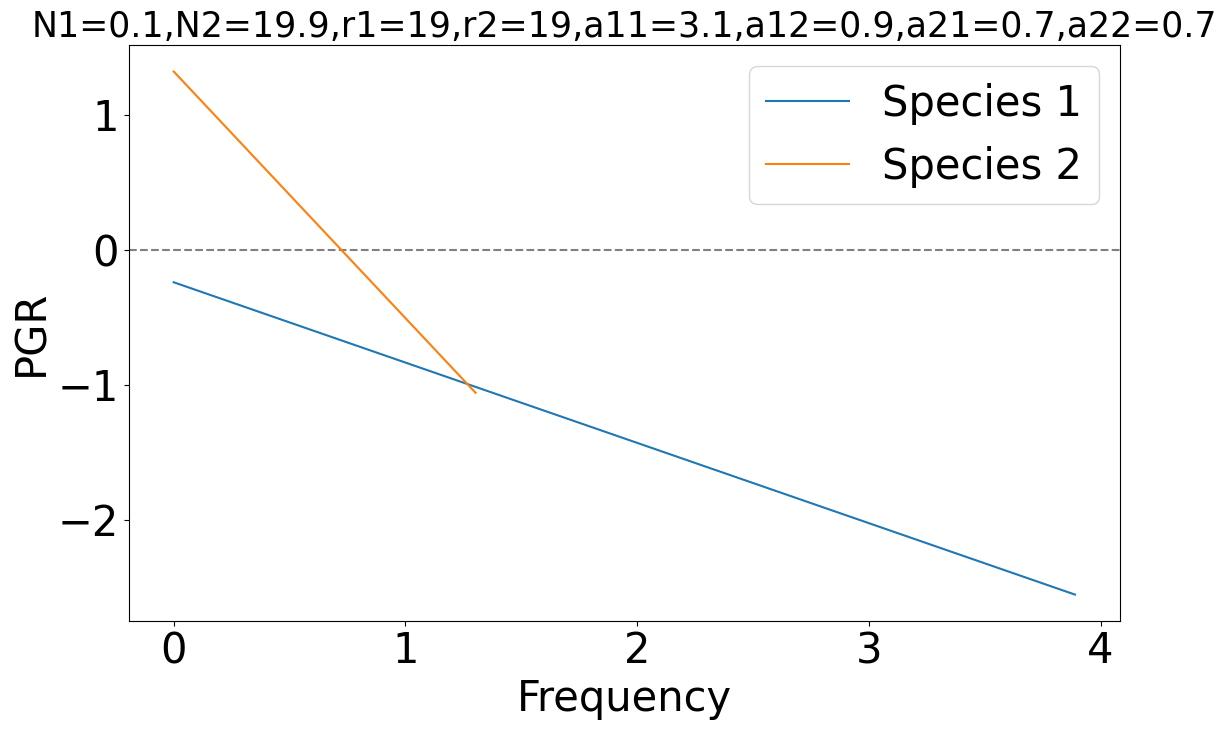

1

In [14]:
r = np.array([r1, r2])
alpha = np.array([[a11, a12], [a21, a22]])
lowN = 0.0001
deltaN = 100 

r1=r[0]
r2=r[1]
a11=alpha[0][0]
a12=alpha[0][1]
a21=alpha[1][0]
a22=alpha[1][1]

test = getNFD(r, alpha, lowN, deltaN)
#print(-1 * (pgr2 - pgr1) / (freq2 - freq1) )

pgr1 = np.array(test['pgr1'])
pgr2 = np.array(test['pgr2'])
freq1 = np.array(test['freq1'])
freq2 = np.array(test['freq2'])

freq1[0] # species1 start x-axis
freq2[0] # species1 end x-axis
pgr1[0] # species1 start y-axis
pgr2[0] # species1 end y-axis

freq1[1] # species2 start x-axis
freq2[1] # species2 end x-axis
pgr1[1] # species2 start y-axis
pgr2[1] # species2 end y-axis

xspecies1=(freq1[0],freq2[0])
yspecies1=(pgr1[0],pgr2[0])
xspecies2=(freq1[1],freq2[1])
yspecies2=(pgr1[1],pgr2[1])

fig, (ax) = plt.subplots(1,figsize=(12, 8))
plt.axhline(y=0, color='grey', linestyle='--')
plt.plot(xspecies1,yspecies1, label='Species 1')
plt.plot(xspecies2,yspecies2, label='Species 2')
plt.xlabel('Frequency')
plt.ylabel('PGR')
plt.legend()
ax.set_title('N1='+str(np.around(N1,1))+',N2='+str(np.around(N2,1))+',r1='+str(np.around(r1,1))+',r2='+str(np.around(r2,1))+',a11='+str(np.around(a11,1))+',a12='+str(np.around(a12,1))+',a21='+str(np.around(a21,1))+',a22='+str(np.around(a22,1)), fontsize=25)
plt.tight_layout()
#plt.savefig('img/frequency_PGR_r1_'+str(np.around(r1,1))+'_r2_'+str(np.around(r2,1))+'_a11_'+str(np.around(a11,1))+'_a12_'+str(np.around(a12,1))+'_a21_'+str(np.around(a21,1))+'_a22_'+str(np.around(a22,1))+'.png', format='png', dpi=50)
plt.show()

# Check if the two curves intersect
check_intercept(xspecies1, yspecies1, xspecies2, yspecies2)
